In [4]:
import theano
import theano.tensor as T

import lasagne

import os
from preproc import pics2array

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from lasagne.layers import get_output, get_all_layers, get_all_params

from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Deconv2DLayer as DeconvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import DenseLayer, InputLayer

from lasagne.nonlinearities  import LeakyRectify, sigmoid
lref = LeakyRectify(0.2)

In [4]:
def buildGenerator(input_shape, input_var=None, n_base_filter=32):
    net = {}
    
    net["input"] = InputLayer(input_shape, input_var)
    
    net["downs_1"] = ConvLayer(net["input"], n_base_filter, 4)
    net["downs_2"] = ConvLayer(net["downs_1"], n_base_filter*2, 4)
    net["downs_3"] = ConvLayer(net["downs_2"], n_base_filter*4, 4)
    net["downs_4"] = ConvLayer(net["downs_3"], n_base_filter*8, 4)
    
    net["upsc_1"] = DeconvLayer(net["downs_4"], n_base_filter*8, 4)
    net["upsc_2"] = DeconvLayer(net["upsc_1"], n_base_filter*4, 4)
    net["upsc_3"] = DeconvLayer(net["upsc_2"], n_base_filter*2, 4)
    net["output"] = DeconvLayer(net["upsc_3"], n_base_filter, 4, nonlinearity=None)
    
    return net

In [5]:
def buildDiscriminator(input_shape, input_var=None, n_base_filter=32):
    net = {}
    
    net["input"] = InputLayer(input_shape, input_var)
    
    net["downs_1"] = ConvLayer(net["input"], n_base_filter, 4, nonlinearity=lref)
    net["downs_2"] = ConvLayer(net["downs_1"], n_base_filter*2, 4, nonlinearity=lref)
    net["downs_3"] = ConvLayer(net["downs_2"], n_base_filter*4, 4, nonlinearity=lref)
    net["downs_4"] = ConvLayer(net["downs_3"], n_base_filter*8, 4, nonlinearity=lref)
    
    net["dense_1"] = DenseLayer(net["downs_4"], 256, nonlinearity=lref)
    net["output"] = DenseLayer(net["dense_1"], 1, nonlinearity=sigmoid)
    
    return net

In [6]:
#defining out variables
#REALLY, REALLY sorry for naming variables like a competitive programmer

picDims = [None, 3, 128, 128]

inputA = T.tensor4("Input of A domain")
inputB = T.tensor4("Input of B domain")

generatorAB = buildGenerator(picDims, inputA) #converts pictures of domain A to domain B
generatorBA = buildGenerator(picDims, inputB) #does the opposite 

outputAB = get_output(generatorAB["output"], {generatorAB["input"] : inputA}) 
outputBA = get_output(generatorBA["output"], {generatorBA["input"] : inputB})

outputABA = get_output(generatorBA["output"], {generatorBA["input"] : outputAB}) 
outputBAB = get_output(generatorAB["output"], {generatorAB["input"] : outputBA})

In [7]:
#now for the discriminator

discriminatorA = buildDiscriminator(picDims)
discriminatorB = buildDiscriminator(picDims)

legit_a_prob = get_output(discriminatorA["output"], {discriminatorA["input"] : inputA})
legit_b_prob = get_output(discriminatorB["output"], {discriminatorB["input"] : inputB})

fake_a_prob = get_output(discriminatorA["output"], {discriminatorA["input"] : outputBA})
fake_b_prob = get_output(discriminatorB["output"], {discriminatorB["input"] : outputAB})

In [13]:
#define our losses
discrimA_loss = -(T.log(legit_a_prob) + T.log(1 - fake_a_prob)).mean()
discrimB_loss = -(T.log(legit_b_prob) + T.log(1 - fake_b_prob)).mean()

discrim_loss = discrimA_loss + discrimB_loss

l1_a_loss = T.abs_(inputA - outputBtoA).mean()
l1_b_loss = T.abs_(inputB - outputAtoB).mean()

gan_loss_a = -(T.log(fake_a_prob)).mean()
gan_loss_b = -(T.log(fake_b_prob)).mean()

generator_loss = l1_a_loss + l1_b_loss + gan_loss_a + gan_loss_b

In [15]:
#compile the functions!

G_AB_params = get_all_params(generatorAtoB["output"], trainable=True)
G_BA_params = get_all_params(generatorBtoA["output"], trainable=True)

G_updates = lasagne.updates.adam(generator_loss, G_AB_params+G_BA_params, 2e-4, beta1=0.5)
G_train = theano.function([inputA, inputB], generator_loss, updates=G_updates, allow_input_downcast=True)

In [16]:
D_A_params = get_all_params(discriminatorA["output"], trainable=True)
D_B_params = get_all_params(discriminatorB["output"], trainable=True)

D_updates = lasagne.updates.adam(discrim_loss, D_A_params + D_B_params)
D_train = theano.function([inputA, inputB], discrim_loss, updates=D_updates, allow_input_downcast=True)

In [3]:
#load data

x = [pic for pic in os.listdir("data/") if pic.split(".")[-1] == "jpg"]
y = [pic for pic in os.listdir("data/") if pic.split(".")[-1] == "png"]

x = pics2array("data/", sorted(x))
y = pics2array("data/", sorted(y))

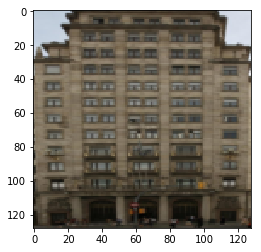

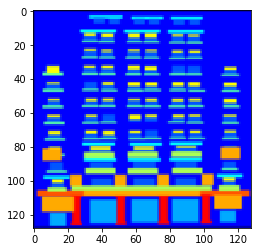

In [5]:
plt.imshow(x[0].transpose(1, 2, 0))
plt.show()

plt.imshow(y[0].transpose(1, 2, 0))
plt.show()